In [20]:
from astropy.io import ascii, fits
from astropy.table import Table, Column, Row, join
from astropy.modeling import models
from astropy import units as u
from astropy import constants as c
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np


from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.spectra import spectrum_mixin as spmx
from specutils.fitting import fit_generic_continuum, fit_lines, find_lines_derivative, find_lines_threshold
from specutils.analysis import equivalent_width, line_flux

from lmfit import Model, Minimizer, Parameters, report_fit

%matplotlib inline


In [2]:
file = '../data/A002532.fits'

In [3]:
data = Table.read(file)
data[:2]

VHELIO,FREQUENCY,FLUX,BASELINE,WEIGHT
km / s,MHz,mJy,mJy,
float64,float64,float32,float64,int16
8129.542851776403,1382.8828641638545,2.002308,-24.838042118727394,0
8126.824776077664,1382.8950711951045,1.2636366,-24.843472509634648,0


In [4]:
data.meta

OrderedDict([('EXTNAME', 'Single Dish'),
             ('OBSERVAT', 'Arecibo Observatory'),
             ('TELESCOP', 'Arecibo Radio Telescope'),
             ('INSTRUME', 'L-Band Wide'),
             ('BACKEND', 'WAPPS'),
             ('NANVALUE', -999.0),
             ('OBJECT', 'A 2532'),
             ('NAME', ''),
             ('HISRC', 'S234027.0+314849'),
             ('ORIGIN', 'Arecibo Observatory'),
             ('RA', 355.11249),
             ('DEC', 31.81361),
             ('HIRA', 355.11249),
             ('HIDEC', 31.81361),
             ('OCRA', 355.11249),
             ('OCDEC', 31.81361),
             ('EQUINOX', 2000.0),
             ('RESTFRQ', 1404060000.0),
             ('BW', 24.987793),
             ('CHAN', 2048),
             ('V21SYS', 4853.95),
             ('comments',
              ['',
               'Arecibo Pisces-Perseus Supercluster Survey (APPSS)',
               'Undergraduate ALFALFA Team (UAT)',
               'Last updated: Tue Jul 23 12:19:55 2019 

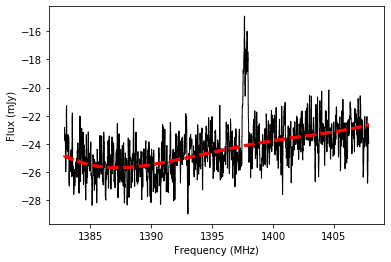

In [5]:
fig, axs = plt.subplots(figsize=(6,4))
axs.plot(data['FREQUENCY'],data['FLUX']+data['BASELINE'],ds='steps-pre', c='k', alpha=1., lw=1.)
axs.plot(data['FREQUENCY'],data['BASELINE'],ds='steps-pre', ls='--',c='r', alpha=1., lw=3.)
#axs.axhline(0.,ls=':',c='r')
axs.set_ylabel('Flux (mJy)')
axs.set_xlabel('Frequency (MHz)')
#axs.set_xlim(3000,7000)
plt.show()

In [6]:
freq = np.array(data['FREQUENCY'])*u.MHz
flux = np.array(data['FLUX']+data['BASELINE'])*u.mJy
spec = Spectrum1D(spectral_axis=freq,flux=flux,velocity_convention="optical",rest_value=1420.405752*u.MHz)
con_fit = fit_generic_continuum(spec)
spec.co = con_fit(freq)
old_co = np.array(data['BASELINE'])*u.mJy

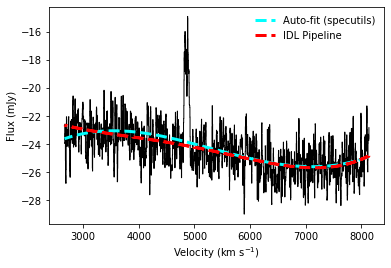

In [7]:
f, ax = plt.subplots()
ax.step(spec.velocity, spec.flux,c='k',lw=1.)
ax.plot(spec.velocity,spec.co,ls='--',c='cyan', alpha=1., lw=3.,label='Auto-fit (specutils)')
ax.step(spec.velocity,old_co, ls='--',c='r', alpha=1., lw=3.,label='IDL Pipeline')
ax.set_ylabel('Flux (mJy)')
#ax.set_xlabel('Frequency (GHz)')
ax.set_xlabel('Velocity (km s$^{-1}$)')
#ax.set_xlim(1.39,1.405)
#ax.set_xlim(4000,6000)
plt.legend(framealpha=0.)
plt.show()

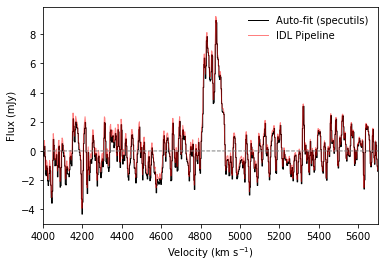

In [8]:
f, ax = plt.subplots()
ax.step(spec.velocity, spec.flux-spec.co,c='k',lw=1.,label='Auto-fit (specutils)')
ax.plot(spec.velocity,spec.flux-old_co,c='r', alpha=.5, lw=1.,label='IDL Pipeline')
ax.plot(spec.velocity,old_co*0., ls='--',c='grey', alpha=1., lw=1.)
ax.set_ylabel('Flux (mJy)')
#ax.set_xlabel('Frequency (GHz)')
ax.set_xlabel('Velocity (km s$^{-1}$)')
#ax.set_xlim(1.39,1.405)
ax.set_xlim(4000,5700)
plt.legend(framealpha=0.)
plt.show()

In [9]:
newspec = Spectrum1D(spectral_axis=spec.frequency,flux=spec.flux-spec.co,velocity_convention="optical",rest_value=1420.405752*u.MHz)

In [10]:
lines = find_lines_derivative(newspec, flux_threshold=5.)
lines

line_center,line_type,line_center_index
GHz,,
float64,str8,int64
1.3975557157263545,emission,1202
1.3976533719763544,emission,1210
1.3977510282263546,emission,1218
1.3978730985388546,emission,1228
1.3979341336951046,emission,1233


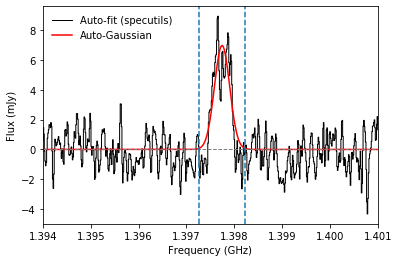

In [11]:
g_init = models.Gaussian1D(amplitude=np.amax(newspec.flux), mean=newspec.frequency[np.where(newspec.flux==np.amax(newspec.flux))], stddev=0.002*u.GHz)
#g_init = models.Gaussian1D(amplitude=6.*u.mJy, mean=4900*u.km/u.s, stddev=40*u.km/u.s)
g_fit = fit_lines(newspec, g_init)
y_fit = g_fit(newspec.frequency)
gmean = g_fit.mean.value*g_fit.mean.unit

f, ax = plt.subplots()
ax.step(spec.frequency, spec.flux-spec.co,c='k',lw=1.,label='Auto-fit (specutils)')
ax.plot(spec.frequency, y_fit, label='Auto-Gaussian',c='r')
ax.plot(spec.frequency,old_co*0., ls='--',c='grey', alpha=1., lw=1.)
ax.axvline(g_fit.mean.value+3*g_fit.stddev.value,ls='--')
ax.axvline(g_fit.mean.value-3*g_fit.stddev.value,ls='--')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Frequency (GHz)')
#ax.set_xlabel('Velocity (km s$^{-1}$)')
ax.set_xlim(1.394,1.401)
#ax.set_xlim(4000,5700)
plt.legend(framealpha=0.)
plt.show()

In [12]:
line_flux(newspec, SpectralRegion(gmean-3*g_fit.stddev, gmean+3*g_fit.stddev))

<Quantity 0.00242906 GHz mJy>

In [13]:
ranint=np.where(np.abs(newspec.frequency-gmean)<=3*g_fit.stddev)
fint=newspec.frequency[ranint]
flint=newspec.flux[ranint]
integrate.trapz(flint,fint)

<Quantity 0.00242142 GHz mJy>

In [15]:
botv3 = c.c.to(u.km/u.s)*(1/(gmean+3*g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
botv2 = c.c.to(u.km/u.s)*(1/(gmean+2*g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
botv1 = c.c.to(u.km/u.s)*(1/(gmean+g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
medv = c.c.to(u.km/u.s)*(1/(gmean)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
topv3 = c.c.to(u.km/u.s)*(1/(gmean-3*g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
topv2 = c.c.to(u.km/u.s)*(1/(gmean-2*g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
topv1 = c.c.to(u.km/u.s)*(1/(gmean-g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
ranint=np.where((newspec.velocity>=botv3)&(newspec.velocity<=topv3))
vint=newspec.velocity[ranint]
flint=newspec.flux[ranint]
integrate.trapz(flint.to(u.Jy),np.flip(vint))

<Quantity 0.52777803 Jy km / s>

In [ ]:
equivalent_width(spec, regions=SpectralRegion(1.396*u.GHz, 1.40*u.GHz))#shift continuum/baseline to +1.

In [21]:
ydata=newspec.flux.value
xdata=newspec.velocity.value
x=np.arange(4500,5001,1)

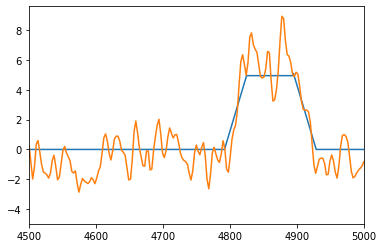

230.0 245.0


In [38]:
y=np.zeros(len(x))
slope1=.15
slope2=-slope1
#g1=np.where((xdata>botv.value)&(xdata<botv2.value))
#g2=np.where((xdata>botv2.value)&(xdata<topv2.value))
#g3=np.where((xdata>topv2.value)&(xdata<topv.value))
g1=np.where((x>botv2.value)&(x<botv1.value))
g2=np.where((x>botv1.value)&(x<topv1.value))
g3=np.where((x>topv1.value)&(x<topv2.value))
y[g1]=slope1*x[g1]-slope1*np.min(x[g1])
y[g2]=slope1*np.max(x[g1])-slope1*np.min(x[g1])
y[g3]=slope2*x[g3]-slope2*np.max(x[g3])
plt.plot(x,y)
plt.plot(xdata,ydata)
plt.xlim(4500,5000)
plt.show()
print(.05*x[100],.05*x[400])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 2048
    # variables        = 8
    chi-square         = 2937.22021
    reduced chi-square = 1.43981383
    Akaike info crit   = 754.508633
    Bayesian info crit = 799.505585
##  Warning: uncertainties could not be estimated:
    s2:  at initial value
    b1:  at initial value
    b2:  at initial value
    t1:  at initial value
    t2:  at initial value
[[Variables]]
    c1:  0.23949824 (init = 3)
    c2: -0.21466725 (init = -3)
    s1: -1149.41505 (init = 0.0002)
    s2: -0.50000000 (init = -0.5)
    b1:  4825.71254 (init = 4825.713)
    b2:  4791.11526 (init = 4791.115)
    t1:  4894.93067 (init = 4894.931)
    t2:  4929.55153 (init = 4929.552)


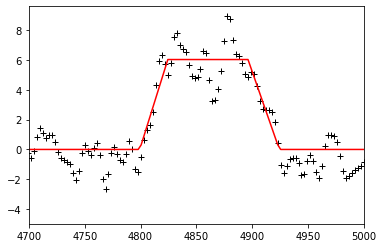

In [83]:
# create data to be fitted
#x = np.linspace(0, 15, 301)
#data = (5.0 * np.sin(2.0*x - 0.1) * np.exp(-x*x*0.025) +
#        np.random.normal(size=x.size, scale=0.2))
x = xdata
data = ydata

botv3 = c.c.to(u.km/u.s)*(1/(gmean+3*g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
botv2 = c.c.to(u.km/u.s)*(1/(gmean+2*g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
botv1 = c.c.to(u.km/u.s)*(1/(gmean+g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
medv = c.c.to(u.km/u.s)*(1/(gmean)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
topv3 = c.c.to(u.km/u.s)*(1/(gmean-3*g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
topv2 = c.c.to(u.km/u.s)*(1/(gmean-2*g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))
topv1 = c.c.to(u.km/u.s)*(1/(gmean-g_fit.stddev)-1/newspec.rest_value.to(u.GHz))/(1/newspec.rest_value.to(u.GHz))

# define objective function: returns the array to be minimized
def fcn2min(params, x, data):
    """Model a decaying sine wave and subtract data."""
    c1 = params['c1']
    c2 = params['c2']
    s1 = params['s1']
    s2 = params['s2']
    b1 = params['b1']
    b2 = params['b2']
    t1 = params['t1']
    t2 = params['t2']
    g1=np.where((x>b2)&(x<b1))
    g2=np.where((x>b1)&(x<t1))
    g3=np.where((x>t1)&(x<t2))
    model = np.zeros(len(x))
    model[g1] = c1*x[g1]+s1
    model[g2] = c1*np.max(x[g1])+s1
    #model[g2] = np.mean(data[g2])
    model[g3] = c2*(x[g3]-np.min(x[g3]))+c1*np.max(x[g1])+s1
    return model - data


# create a set of Parameters
params = Parameters()
params.add('c1', value=3.)
params.add('c2', value=-3.)
params.add('s1', value=0.0002)
params.add('s2',value=-0.5,max=0.)
params.add('b1', value=botv1.value)
params.add('b2', value=botv2.value)
params.add('t1', value=topv1.value)
params.add('t2', value=topv2.value)

# do fit, here with the default leastsq algorithm
minner = Minimizer(fcn2min, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
final = data + result.residual
final[final<0]=0

# write error report
report_fit(result)

# try to plot results
try:
    import matplotlib.pyplot as plt
    plt.plot(x, data, 'k+')
    plt.plot(x, final, 'r')
    plt.xlim(4700,5000)
    plt.show()
except ImportError:
    pass

In [89]:
flux=u.mJy*u.km/u.s*integrate.trapz(final[np.where((x>result.params['b2'].value)&(x<result.params['t2'].value))],np.flip(x[np.where((x>result.params['b2'].value)&(x<result.params['t2'].value))]))
flux.to(u.Jy*u.km/u.s)

<Quantity 0.59435232 Jy km / s>